In [5]:
# beta and eta, initial state normalized

from scipy.integrate import solve_ivp # ordinary diff equations solver
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

font = {'size':15}

plt.rc('font', **font)

# functions used
def flatten_list(regular_list):
    transformed_list = [item for sublist in regular_list for item in sublist]
    return transformed_list

def seir_function(t, y, beta, eta, Z, D, gamma):
    S, E, I, R, V = y
    N = S + E + I + R + V # total population size

    dSdt = (-beta/N)*S*I + eta*R - gamma*S
    dEdt = (beta/N)*S*I - (1/Z)*E
    dIdt = (1/Z)*E - (1/D)*I 
    dRdt = (1/D)*I - eta*R + gamma*S
    dVdt = 0

    return np.array([dSdt, dEdt, dIdt, dRdt, dVdt], dtype=object)

def error_obj_function(beta_eta_Z_D, gamma, t_start, t_end, initial_state, data_daily_infections):
    model = solve_ivp(
                    seir_function,
                    (0, t_end-t_start),
                    initial_state,
                    'RK45',
                    t_eval = range(0, t_end-t_start, 1),
                    args = [beta_eta_Z_D[0], beta_eta_Z_D[1], beta_eta_Z_D[2], beta_eta_Z_D[3], gamma]
                )
    model_output = np.diff(model.y[2], n=1) + np.diff(model.y[3], n=1)
    error = np.power(model_output - data_daily_infections, 2).sum()
    return error

def simulate(beta_guess, eta_guess, Z_inv_guess, D_inv_guess, gamma, t_start, t_end, initial_state, data_daily_infections, x_range_dates=[], plot_results=False, verbose=False):

    model = solve_ivp(
        seir_function,
        (0, t_end-t_start),
        initial_state,
        'RK45',
        t_eval = range(0, t_end-t_start, 1),
        args = [beta_guess, eta_guess, Z_inv_guess, D_inv_guess, gamma]
    )
    
    optimization = minimize(
        error_obj_function,
        [beta_guess, eta_guess, Z_inv_guess, D_inv_guess],
        method = 'Nelder-Mead',
        tol = 1e-3,
        bounds = [(0,1), (0,1), (0, 7), (0, 30)],
        args = (gamma, t_start, t_end, initial_state, data_daily_infections)
    )
    
    beta_optimized = optimization.x[0]
    eta_optimized = optimization.x[1]
    Z_inv_optimized = optimization.x[2]
    D_inv_optimized = optimization.x[3]

    model_optimized = solve_ivp(
        seir_function,
        (0, t_end-t_start),
        initial_state,
        'RK45',
        t_eval = range(0, t_end-t_start, 1),
        args = [beta_optimized, eta_optimized, Z_inv_optimized, D_inv_optimized, gamma]
    )

    if verbose:
        print('beta = {}, eta = {},  z_inv = {}, d_inv = {} \n Data inicial = {}, Data final = {}'.format(beta_optimized, eta_optimized, Z_inv_optimized, D_inv_optimized, x_range_dates[0], x_range_dates[-1]))
        print('Optimized model compartments: S = {}, E = {}, I = {}, R = {}, V = {}'.format(model_optimized.y[0][-1],model_optimized.y[1][-1],model_optimized.y[2][-1],model_optimized.y[3][-1],model_optimized.y[4][-1]))
        
    if plot_results:
        model_daily_infections = np.diff(model.y[2], n=1) + np.diff(model.y[3], n=1)
        model_optimized_daily_infections = np.diff(model_optimized.y[2], n=1) + np.diff(model_optimized.y[3], n=1)
        
        fig, ax = plt.subplots(3,1, figsize=(15,8))

        #fig.suptitle('Infection rate = {}, Reinfection rate = {}, \n Start date = {}, End date = {}'.format(np.round(beta_optimized,3), np.round(eta_optimized,3), x_range_dates[0], x_range_dates[-1]))

        ax[0].plot(x_range_dates, data_daily_infections, color = 'black')
        ax[0].plot(x_range_dates, model_daily_infections[:len(x_range_dates)], color = 'black', linestyle = 'dotted') 
        ax[0].plot(x_range_dates, model_optimized_daily_infections[:len(x_range_dates)], color = 'black', linestyle = 'dashed')  
        ax[0].legend(['Daily real cases', 'Modelo com parâmetros calculados', 'Modelo com parâmetros otimizados'])
        ax[0].set_title('Acurácia do modelo')
        ax[0].set_ylim([0, 0.001])
        ax[0].tick_params(axis = 'x', labelrotation = 45)

        ax[1].plot(x_range_dates, model.y[0][:len(x_range_dates)], color = 'green')   
        ax[1].plot(x_range_dates, model.y[1][:len(x_range_dates)], color = 'orange')   
        ax[1].plot(x_range_dates, model.y[2][:len(x_range_dates)], color = 'red') 
        ax[1].plot(x_range_dates, model.y[3][:len(x_range_dates)], color = 'gray')   
        ax[1].plot(x_range_dates, model.y[4][:len(x_range_dates)], color = 'blue')
        ax[1].legend(['S', 'E', 'I', 'R', 'V'])
        ax[1].set_title('Simulação sem otimização')
        ax[1].set_yscale('log')
        ax[1].set_ylim([1e-4, 1])
        ax[1].tick_params(axis = 'x', labelrotation = 45)

        ax[2].sharey(ax[1])
        ax[2].plot(x_range_dates, model_optimized.y[0][:len(x_range_dates)], color = 'green')   
        ax[2].plot(x_range_dates, model_optimized.y[1][:len(x_range_dates)], color = 'orange')   
        ax[2].plot(x_range_dates, model_optimized.y[2][:len(x_range_dates)], color = 'red') 
        ax[2].plot(x_range_dates, model_optimized.y[3][:len(x_range_dates)], color = 'gray')   
        ax[2].plot(x_range_dates, model_optimized.y[4][:len(x_range_dates)], color = 'blue')
        ax[2].legend(['S', 'E', 'I', 'R', 'V'])
        ax[2].set_title('Simulação com parâmetros otimizados')
        ax[2].set_yscale('log')
        ax[2].set_ylim([1e-4, 1])
        ax[2].tick_params(axis = 'x', labelrotation = 45)

        fig.tight_layout()

    return model, model_optimized, beta_optimized, eta_optimized, Z_inv_optimized, D_inv_optimized

def parse_infection_data(t_start, t_end, country, total_population):
    # data used
    main_data = pd.read_csv('owid-covid-data.csv')
    country_data = main_data.loc[main_data['location'] == country].copy()
    data_daily_infections = country_data.new_cases.interpolate().rolling(7).mean().fillna(0).values[t_start:t_end-1]
    new_daily_vaccinated_people = country_data.new_vaccinations_smoothed.fillna(0).values[t_start:t_end-1]
    country_data['date'] = pd.to_datetime(country_data['date'])
    country_data.reset_index(inplace = True)
    country_data = country_data.drop('index', axis = 1)

    data_daily_infections = data_daily_infections/total_population
    new_daily_vaccinated_people = new_daily_vaccinated_people/total_population

    # enrich data with variants
    # variant data was removed from owid due to licensing issues. 
    # analysed charts directly
    # dominance threshold: >=70% dominia

    dict_variants = {
        'start_date' :[
            '2020-01-03',
            '2021-03-01',
            '2021-09-13',
            '2022-01-03',
            '2022-04-25',
            '2022-07-18',
            '2023-01-02',
            '2023-02-27'
        ],
        'end_date' :[
            '2021-02-28',
            '2021-09-12',
            '2022-01-02',
            '2022-04-24',
            '2022-07-17',
            '2023-01-01',
            '2023-02-26',
            '2023-06-13'
        ],
        'top_variant' : [
            'sem significância',
            'gamma',
            'delta',
            'omicron ba1',
            'omicron ba2',
            'omicron ba5',
            'omicron bq1',
            'omicron xbb15'
        ]
    }

    variants = pd.DataFrame(dict_variants)
    variants['start_date'] = pd.to_datetime(variants['start_date'])
    variants['end_date'] = pd.to_datetime(variants['end_date'])

    country_data_variants = []
    for _, row in country_data.iterrows():
        date = row['date']
        matching_interval = variants[(variants['start_date'] <= date) & (variants['end_date'] >= date)]
        if not matching_interval.empty:
            info = matching_interval['top_variant'].values[0]
        else:
            info = None
        country_data_variants.append(info)

    country_data['top_variant'] = country_data_variants

    x_range_dates = list(country_data['date'][t_start:t_end-1])

    return data_daily_infections, x_range_dates, country_data, new_daily_vaccinated_people


Mean error: 1.2468060712783321e-07, error standard deviation: 1.6330036667998056e-05, r2_score: 0.9874405808826286


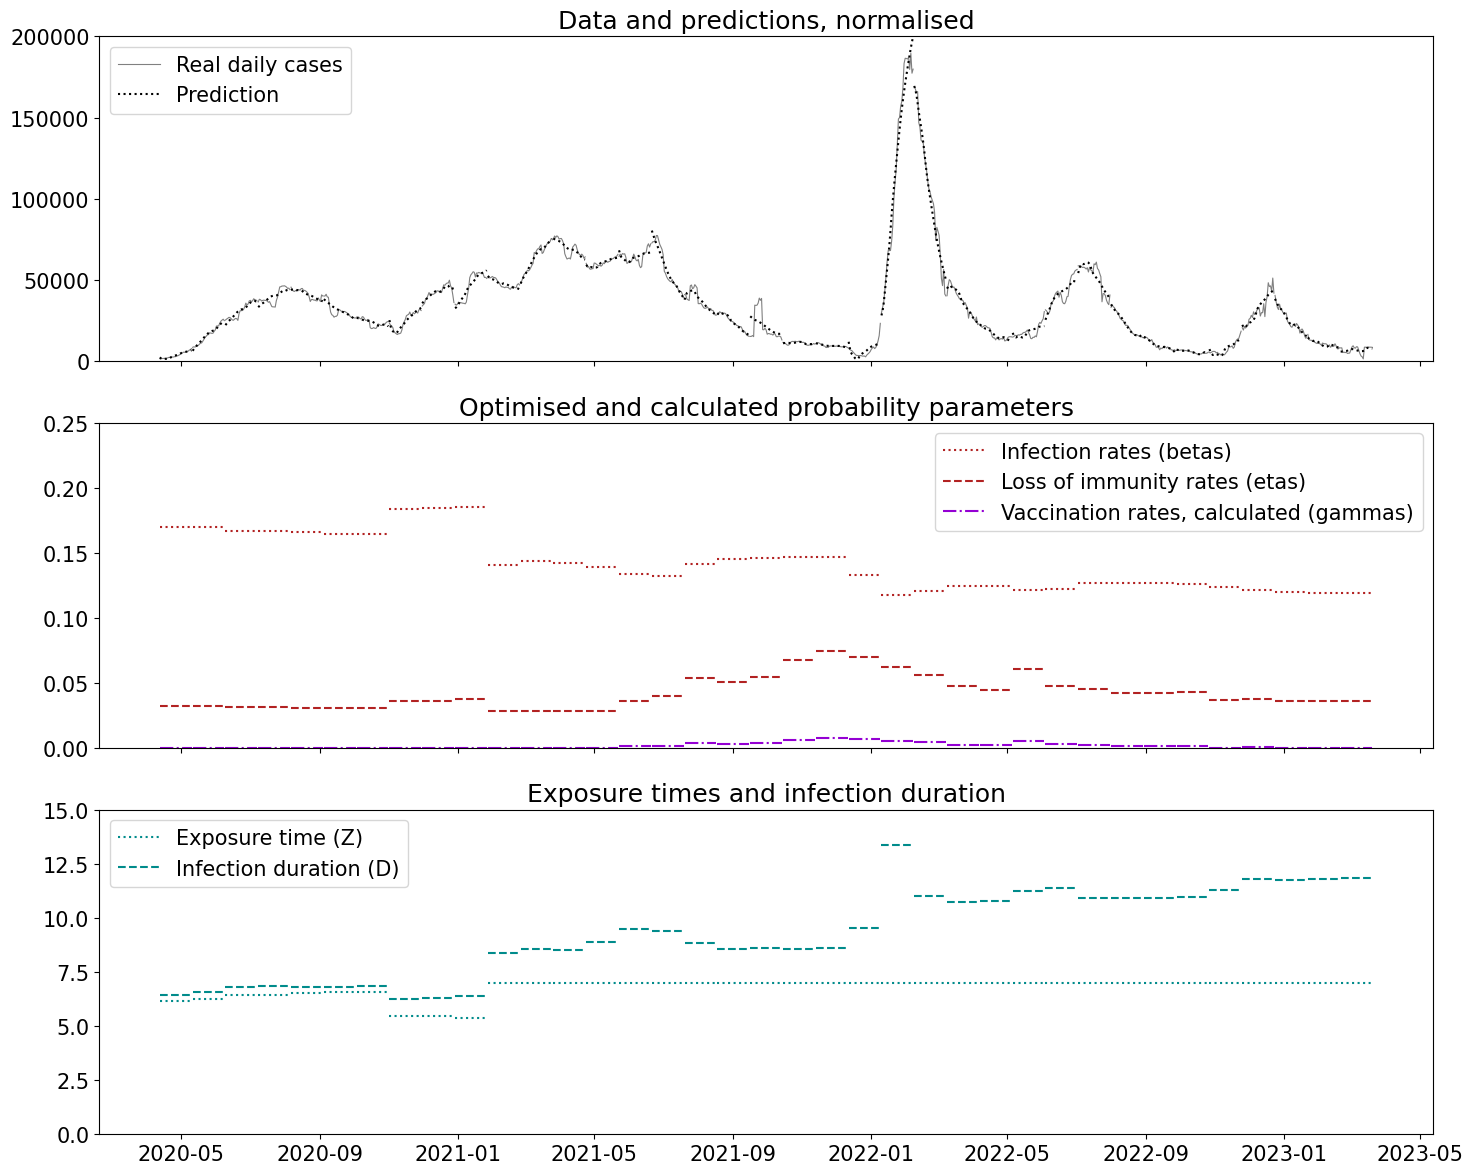

In [7]:
beta_guess = 0.1 # beta inicial = R0 / infection duration
eta_guess = 0.01
Z_inv_guess = 3.69
D_inv_guess = 7

window_size = 30

gamma = 0

S, E, I, R, V = 1, 0.01, 0.01, 0.05, 0 # E is cumulative infected times R0 at the moment
initial_state = [S-E-I-R-V, E, I, R, V]

country = 'Brazil'
total_population = 2e8

start_simulation_days = 100

data_daily_infections_all, x_range_dates, country_data, new_daily_vaccinated_people_all = parse_infection_data(0, 1203, country, total_population)
data_daily_infections_all = data_daily_infections_all[start_simulation_days:]
x_range_dates = x_range_dates[start_simulation_days:]
country_data = country_data[start_simulation_days:]

variants = country_data['top_variant'].unique()

betas = []
etas = []
r2s = []
stdevs = []
avgs = []

fig, ax = plt.subplots(3, 1, figsize = (15,12), sharex = True)

x_min = 0

model_pred = []
error = []

for window in range(0, data_daily_infections_all.shape[0], window_size):
    x_max = x_min + window_size-1

    t_start = 0
    t_end = window_size

    data_daily_infections = data_daily_infections_all[x_min:x_max]
    new_daily_vaccinated_people = new_daily_vaccinated_people_all[x_min:x_max]
    gamma = new_daily_vaccinated_people_all[x_min:x_max].min()
    x_range = x_range_dates[x_min:x_max]

    x_min = x_max
    middle = x_range[int(len(x_range)/2)]

    # simulation with gamma involved
    model, model_optimized, beta_optimized, eta_optimized, Z_inv_optimized, D_inv_optimized = simulate(beta_guess, eta_guess, Z_inv_guess, D_inv_guess, gamma, t_start, t_end, initial_state, data_daily_infections)
 
    # update initial state and guesses
    beta_guess = beta_optimized
    eta_guess = eta_optimized
    Z_inv_guess = Z_inv_optimized
    D_inv_guess = D_inv_optimized


    beta_plot = beta_optimized * np.ones(window_size-1)
    eta_plot = eta_optimized * np.ones(window_size-1)
    Z_inv_plot = Z_inv_optimized * np.ones(window_size-1)
    D_inv_plot = D_inv_optimized * np.ones(window_size-1)
    gamma_plot = gamma * np.ones(window_size-1)

    initial_state = [
        model_optimized.y[0][-1],
        model_optimized.y[1][-1],
        model_optimized.y[2][-1],
        model_optimized.y[3][-1],
        model_optimized.y[4][-1]
    ]

    model_daily_infections = np.diff(model.y[2], n=1) + np.diff(model.y[3], n=1)
    model_optimized_daily_infections = np.diff(model_optimized.y[2], n=1) + np.diff(model_optimized.y[3], n=1)

    r2 = r2_score(data_daily_infections, model_optimized_daily_infections)
    avg = np.mean(model_optimized_daily_infections - data_daily_infections)
    stdev = np.std(model_optimized_daily_infections - data_daily_infections)
    

    model_pred.extend(model_optimized_daily_infections)
    error.extend(model_optimized_daily_infections - data_daily_infections)
    r2s.append(r2)
    stdevs.append(stdev)
    avgs.append(avg)

    ax[0].plot(x_range, data_daily_infections * total_population, color = 'gray', lw = 0.8)
    #ax[0].plot(x_range, model_daily_infections * total_population, color = 'black', linestyle = 'dotted')
    ax[0].plot(x_range, model_optimized_daily_infections * total_population, color = 'black', linestyle = 'dotted')
    ax[0].set_title('Data and predictions, normalised')
    ax[0].legend(['Real daily cases', 'Prediction'], loc = 'upper left')
    ax[0].set_ylim([0, 2e5])

    ax[1].plot(x_range, beta_plot, color = 'firebrick', linestyle = 'dotted')
    ax[1].plot(x_range, eta_plot, color = 'firebrick', linestyle = 'dashed')
    ax[1].plot(x_range, gamma_plot, color = 'darkviolet', linestyle = 'dashdot')
    ax[1].set_title('Optimised and calculated probability parameters')
    ax[1].legend(['Infection rates (betas)', 'Loss of immunity rates (etas)', 'Vaccination rates, calculated (gammas)'])
    ax[1].set_ylim([0, 0.25])

    ax[2].plot(x_range, Z_inv_plot, color = 'darkcyan', linestyle = 'dotted')
    ax[2].plot(x_range, D_inv_plot, color = 'darkcyan', linestyle = 'dashed')
    ax[2].set_title('Exposure times and infection duration')
    ax[2].legend(['Exposure time (Z)', 'Infection duration (D)'])
    ax[2].set_ylim([0, 15])

r2 = r2_score(data_daily_infections_all[:len(model_pred)], model_pred)

print('Mean error: {}, error standard deviation: {}, r2_score: {}'.format(np.array(error).mean(), np.array(error).std(), r2))

fig.tight_layout()